In [1]:
import numpy as np
import pandas as pd

from catboost import Pool, CatBoostRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
df = pd.read_csv("pharmacy_new.csv")
df =df.drop(columns=['tx_date', 'drug', 'diagnosis_letter', 'diagnosis_number','Unnamed: 0'])
df = df[df['rejected'] == False]
df = df.drop(columns='rejected')

In [3]:
train,test= train_test_split(df,test_size=0.2, shuffle=True, random_state=42)
train_temp=train
test_temp=test

In [5]:


# Feature 1
# grouping by 'drug', 'pharmacy' and 'bin'.
temp = train_temp.groupby(['drug_name','pharmacy','bin'],as_index=False).patient_pay.mean()
temp['drug_phar_bin'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug_name','pharmacy','bin'], how='left')


# Feature 2
# grouping by 'drug','pharmacy' and 'group'.
temp = train_temp.groupby(['drug_name','pharmacy','group'],as_index=False).patient_pay.mean()
temp['drug_phar_grp'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug_name','pharmacy','group'], how='left')
# some rows have group missing so we impute those values with 'drug_phar_bin'
train_temp['drug_phar_grp']=train_temp['drug_phar_grp'].fillna(train_temp['drug_phar_bin'])


# Feature 3
# grouping by 'drug','pharmacy' and 'pcn'.
temp = train_temp.groupby(['drug_name','pharmacy','pcn'],as_index=False).patient_pay.mean()
temp['drug_phar_pcn'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug_name','pharmacy','pcn'], how='left')
# some rows have pcn missing so we impute those values with 'drug_phar_bin'
train_temp['drug_phar_pcn']=train_temp['drug_phar_pcn'].fillna(train_temp['drug_phar_bin'])


# Feature 4
# grouping by 'drug','pharmacy'.
temp = train_temp.groupby(['drug_name','pharmacy'],as_index=False).patient_pay.mean()
temp['drug_phar'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug_name','pharmacy'], how='left')


# Feature 5
# grouping by 'drug' and 'diagnosis'.
temp = train_temp.groupby(['drug_name','diagnosis'],as_index=False).patient_pay.mean()
temp['drug_diag'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug_name','diagnosis'], how='left')


# Feature 6
# grouping by 'drug' and 'bin'.
temp = train_temp.groupby(['drug_name','bin'],as_index=False).patient_pay.quantile(0.75)
temp['drug_bin'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug_name','bin'], how='left')


# Feature 7
# grouping by 'drug' and 'group'.
temp = train_temp.groupby(['drug_name','group'],as_index=False).patient_pay.quantile(0.75)
temp['drug_grp'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug_name','group'], how='left')
# some rows have group missing so we impute those values with 'drug_phar_bin'
train_temp['drug_grp']=train_temp['drug_grp'].fillna(train_temp['drug_bin'])


# Feature 8
# grouping by 'drug' and 'pcn'.
temp = train_temp.groupby(['drug_name','pcn'],as_index=False).patient_pay.quantile(0.75)
temp['drug_pcn'] = temp['patient_pay']
del temp['patient_pay']
train_temp = pd.merge(train_temp,temp,on=['drug_name','pcn'], how='left')
# some rows have pcn missing so we impute those values with 'drug_phar_bin'
train_temp['drug_pcn']=train_temp['drug_pcn'].fillna(train_temp['drug_bin'])



In [6]:
cols=['drug_phar_bin', 'drug_phar_grp','drug_phar_pcn', 
    'drug_phar', 'drug_diag', 'drug_bin', 'drug_grp',
    'drug_pcn',
     'brand']

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

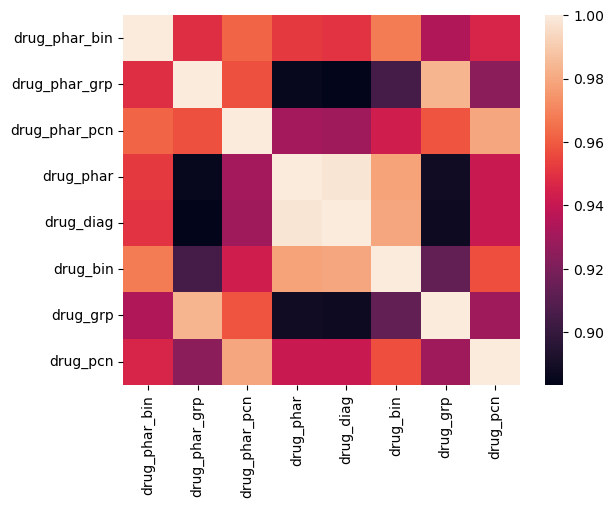

In [9]:
sns.heatmap(train_temp[cols].corr())  

In [18]:
train_data = train_temp[cols].astype('string')
train_label = train_temp['patient_pay']
train_pool = Pool(train_data, train_label, cat_features = list(range(len(cols))))

In [19]:
model = CatBoostRegressor(iterations =50, 
                         depth = 8,
                         learning_rate=1,
                         loss_function = 'RMSE')
model.fit(train_pool)

0:	learn: 23.3924765	total: 10.7s	remaining: 8m 46s
1:	learn: 22.6647720	total: 16.2s	remaining: 6m 28s
2:	learn: 22.4148449	total: 22.2s	remaining: 5m 47s
3:	learn: 22.2624066	total: 27.7s	remaining: 5m 18s
4:	learn: 22.2231110	total: 32.4s	remaining: 4m 51s
5:	learn: 22.0946323	total: 37.6s	remaining: 4m 35s
6:	learn: 22.0704127	total: 42.3s	remaining: 4m 20s
7:	learn: 22.0414902	total: 47s	remaining: 4m 6s
8:	learn: 22.0252065	total: 51.7s	remaining: 3m 55s
9:	learn: 21.9985544	total: 56.4s	remaining: 3m 45s
10:	learn: 21.9828119	total: 1m 1s	remaining: 3m 36s
11:	learn: 21.9553913	total: 1m 5s	remaining: 3m 28s
12:	learn: 21.9194164	total: 1m 10s	remaining: 3m 21s
13:	learn: 21.9071083	total: 1m 15s	remaining: 3m 14s
14:	learn: 21.8939484	total: 1m 20s	remaining: 3m 6s
15:	learn: 21.8888061	total: 1m 24s	remaining: 3m
16:	learn: 21.8572179	total: 1m 29s	remaining: 2m 54s
17:	learn: 21.8496393	total: 1m 34s	remaining: 2m 48s
18:	learn: 21.8425596	total: 1m 39s	remaining: 2m 42s
19:	

In [21]:
from catboost import CatBoost
modelC = CatBoost({'iterations':100})
modelC.fit(train_pool)

Learning rate set to 0.5
0:	learn: 29.2343923	total: 7.7s	remaining: 12m 42s
1:	learn: 24.8861106	total: 13.3s	remaining: 10m 50s
2:	learn: 23.3449175	total: 17.8s	remaining: 9m 36s
3:	learn: 22.8069248	total: 22.5s	remaining: 8m 59s
4:	learn: 22.6345051	total: 26.6s	remaining: 8m 25s
5:	learn: 22.5453425	total: 30.5s	remaining: 7m 57s
6:	learn: 22.3898386	total: 34.8s	remaining: 7m 42s
7:	learn: 22.3398514	total: 38.7s	remaining: 7m 25s
8:	learn: 22.3156304	total: 42.6s	remaining: 7m 10s
9:	learn: 22.2612389	total: 46.3s	remaining: 6m 56s
10:	learn: 22.2264357	total: 50.7s	remaining: 6m 50s
11:	learn: 22.1910153	total: 54.7s	remaining: 6m 40s
12:	learn: 22.1735126	total: 58.7s	remaining: 6m 32s
13:	learn: 22.1622012	total: 1m 2s	remaining: 6m 24s
14:	learn: 22.1267025	total: 1m 6s	remaining: 6m 19s
15:	learn: 22.1160130	total: 1m 10s	remaining: 6m 12s
16:	learn: 22.1099974	total: 1m 14s	remaining: 6m 6s
17:	learn: 22.0828765	total: 1m 18s	remaining: 5m 59s
18:	learn: 22.0562724	total:

In [22]:
cols2=['drug_phar_bin', 'drug_phar_grp','drug_phar_pcn', 
    'drug_phar', 'drug_diag', 'drug_bin', 'drug_grp',
    'drug_pcn',
     'brand', 'month']
train_data2 = train_temp[cols2].astype('string')
train_pool2 = Pool(train_data2, train_label, cat_features = list(range(len(cols2))))

In [23]:
model22 = CatBoostRegressor(iterations =50, 
                         depth = 8,
                         learning_rate=1,
                         loss_function = 'RMSE')
model22.fit(train_pool2)

0:	learn: 23.2894685	total: 9.51s	remaining: 7m 45s
1:	learn: 22.6189221	total: 16.8s	remaining: 6m 44s
2:	learn: 22.3281686	total: 24.8s	remaining: 6m 29s
3:	learn: 22.2124540	total: 30.6s	remaining: 5m 52s
4:	learn: 22.1045286	total: 36.4s	remaining: 5m 27s
5:	learn: 22.0734374	total: 43.1s	remaining: 5m 16s
6:	learn: 22.0397559	total: 48.7s	remaining: 4m 59s
7:	learn: 22.0178897	total: 54.3s	remaining: 4m 45s
8:	learn: 21.9662713	total: 1m	remaining: 4m 34s
9:	learn: 21.9524046	total: 1m 5s	remaining: 4m 23s
10:	learn: 21.9212958	total: 1m 11s	remaining: 4m 12s
11:	learn: 21.9055284	total: 1m 16s	remaining: 4m 2s
12:	learn: 21.8944655	total: 1m 22s	remaining: 3m 53s
13:	learn: 21.8707117	total: 1m 27s	remaining: 3m 45s
14:	learn: 21.8643208	total: 1m 33s	remaining: 3m 37s
15:	learn: 21.8568651	total: 1m 38s	remaining: 3m 29s
16:	learn: 21.8333255	total: 1m 44s	remaining: 3m 22s
17:	learn: 21.8235278	total: 1m 49s	remaining: 3m 14s
18:	learn: 21.8187995	total: 1m 55s	remaining: 3m 7s

In [24]:
model22 = CatBoostRegressor(iterations =50, 
                         depth = 10,
                         learning_rate=1,
                         loss_function = 'RMSE')
model22.fit(train_pool2)

0:	learn: 23.1690599	total: 11.2s	remaining: 9m 9s
1:	learn: 22.3871473	total: 19.8s	remaining: 7m 54s
2:	learn: 22.2191444	total: 27.9s	remaining: 7m 16s
3:	learn: 22.1609204	total: 35.3s	remaining: 6m 46s
4:	learn: 22.0407047	total: 42.5s	remaining: 6m 22s
5:	learn: 22.0102843	total: 49s	remaining: 5m 59s
6:	learn: 21.9304620	total: 55.6s	remaining: 5m 41s
7:	learn: 21.8869695	total: 1m 1s	remaining: 5m 25s
8:	learn: 21.8560129	total: 1m 8s	remaining: 5m 11s
9:	learn: 21.8456341	total: 1m 15s	remaining: 5m
10:	learn: 21.8289104	total: 1m 21s	remaining: 4m 49s
11:	learn: 21.8149604	total: 1m 28s	remaining: 4m 39s
12:	learn: 21.7814893	total: 1m 34s	remaining: 4m 29s
13:	learn: 21.7609355	total: 1m 41s	remaining: 4m 19s
14:	learn: 21.7507895	total: 1m 47s	remaining: 4m 11s
15:	learn: 21.7455446	total: 1m 54s	remaining: 4m 2s
16:	learn: 21.7319812	total: 2m	remaining: 3m 53s
17:	learn: 21.7261093	total: 2m 7s	remaining: 3m 45s
18:	learn: 21.7139205	total: 2m 13s	remaining: 3m 37s
19:	le

In [ ]:
test_temp = pd.merge(test_temp, train_temp[['drug','pharmacy','bin','drug_phar_bin']].drop_duplicates().dropna(),on=['drug','pharmacy','bin'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','pharmacy','group','drug_phar_grp']].drop_duplicates().dropna(),on=['drug','pharmacy','group'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','pharmacy','pcn','drug_phar_pcn']].drop_duplicates().dropna(),on=['drug','pharmacy','pcn'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','pharmacy','drug_phar']].drop_duplicates().dropna(),on=['drug','pharmacy'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','diagnosis','drug_diag']].drop_duplicates().dropna(),on=['drug','diagnosis'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','bin','drug_bin']].drop_duplicates().dropna(),on=['drug','bin'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','group','drug_grp']].drop_duplicates().dropna(),on=['drug','group'], how='left')
test_temp = pd.merge(test_temp, train_temp[['drug','pcn','drug_pcn']].drop_duplicates().dropna(),on=['drug','pcn'], how='left')

test_temp['drug_grp']=test_temp['drug_grp'].fillna(test_temp['drug_bin'])
test_temp['drug_pcn']=test_temp['drug_pcn'].fillna(test_temp['drug_bin'])
test_temp['drug_phar_bin']=test_temp['drug_phar_bin'].fillna(test_temp['drug_bin'])
test_temp['drug_phar_grp']=test_temp['drug_phar_grp'].fillna(test_temp['drug_phar_bin'])
test_temp['drug_phar_pcn']=test_temp['drug_phar_pcn'].fillna(test_temp['drug_phar_bin'])



In [ ]:



test_data = test.drop(columns=['patient_pay'])
test_label = test['patient_pay']
preds=model.predict(test_data)
diff = preds - test_label
diff.describe()